# time series forecasting with regression

We've walked through time series forecasting using only past values of the forecast variable $y$ — check out the "time series forecasting basics" notebook — but now we'd like to forecast a variable using one or multiple predictor variables $x$. This task calls for time series regression models.

In the simplest case, we have a single forecast variable and a single predictor variable, related linearly: $y_{t} = \beta_{0} + \beta_{1} x_{t} + \epsilon_{t}$. The model's parameters include an intercept $\beta_{0}$, slope $\beta_{1}$, and "error" $\epsilon_{t}$ describing deviations between the straight line prediction and actual observations — basically, everything affecting $y_{t}$ other than $x_{t}$. When there are multiple predictor variables, we generalize simple linear regression into a multiple regresison model: $y_{t} = \beta_{0} + \beta_{1} x_{1,t} + \cdots + \beta_{k} x_{k, t} + \epsilon_{t}$, where $k$ is the number of predictor variables and $\beta$ coefficients represent the marginal effects of each predictor on the forecast variable.

When using linear regression, we're making some key assumptions about the errors $\epsilon_{t}$:

- they have a mean of zero, otherwise forecasts will be biased
- (ideally) they're normally distributed with constant variance, otherwise forecast intervals will be more work
- they're not autocorrelated, otherwise the model isn't using all available information
- they're unrelated to the predictor variables, otherwise we're not providing enough information to the model

## technical setup

If you haven't done this already...

```
$ git clone git@github.com:bdewilde/time-series-forecasting-study.git
$ cd time-series-forecasting-study
$ pip install -e .
$ pip install -e .[dev]
```

In [162]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.model_selection
import statsmodels.api as sm

import data_dives
from data_dives import time_series_forecasting as tsf

In [163]:
# set some default plot params
plt.rcParams.update(
    {
        "figure.figsize": (16, 6),
        "figure.facecolor": "white",
        "axes.labelsize": "x-large",
        "legend.fontsize": "x-large",
        "legend.frameon": False,
        "lines.linewidth": 2,
    }
)

### problem definition

Let's build on our "basic" exploration into forecasting atmospheric CO2 concentrations, and now use it as a _predictor_ variable for global temperature forecasts. The original problem definition just needs a couple tweaks:

Climate change is a large and growing existential threat to life on our planet, and global warming is a particularly notable component of these changes. Human-caused emission of greenhouse gasses (GHGs) into the atmosphere is a direct and dominant driver of global warming. Can we predict future global temperatures over the course of the next ten years based on different GHG emission scenarios, in order to show a reasonable range of possible climate futures?

### information gathering

Global warming is driven by the increasing concentration of GHGs in the atmosphere, as predominantly emitted by humans [[source](https://climate.nasa.gov/causes/)]. We previously found that a good, long-term source of atmospheric CO2 concentration measurements is the Mauna Loa Observatory, so we'll use that dataset for our predictor variable. (Other variables affecting global temperature include aerosols and solar activity, but corresponding datasets are lacking.)

Measuring average global temperature is more difficult than one might expect; in practice, scientists typically consider temperature _anomalies_ that indicate how much warmer / colder it is than "normal" for a particular place and time [[source](https://data.giss.nasa.gov/gistemp/faq/abs_temp.html)]. This process requires combining thousands of land- and sea-based measurements, normalizing them against appropriate historical averages to produce temperature "anomalies", splitting the globe up into a grid and averaging over each square, filling gaps in coverage, then repeating this process over and over in time [[source](https://www.carbonbrief.org/explainer-how-do-scientists-measure-global-temperature)].

#### data acquisition

Several independent datasets exist with such information, including NASA's GISS Surface Temperature analysis ([GISTEMP](https://data.giss.nasa.gov/gistemp)) and NOAA's Merged Land–Ocean Surface Temperature analysis ([MLOST](https://www.ncdc.noaa.gov/data-access/marineocean-data/mlost)). They differ in their spatial coverage and how they handle measurement errors / changes, among other things. Since GISTEMP is well-known and has the best global coverage, let's go with it. Some important details:

- GISTEMP uses 1951-1980 as the reference period against which anomalies are determined
- measurements are available from 1880–present, where the starting point was decided by 19th-century data quality issues
- values are "Land-Ocean Temperature Index" (LOTI) anomalies that combine land surface air temps and sea surface temps, in units of degrees Celsius
- we're using data with monthly temporal resolution and global spatial resolution

In [164]:
dataset_temp = data_dives.datasets.GISTEMP()
dataset_temp.info

{'name': 'GISTEMP',
 'site_url': 'https://data.giss.nasa.gov/gistemp',
 'description': 'Estimates of global surface temperature change based on combined land-surface air and sea-surface water temperature anomalies, expressed as a Land-Ocean Temperature Index (LOTI) measured relative to average temps over 1951-1980 for the given place and time of year. Global mean with monthly resolution, 1880 – Present.',
 'citation': 'Lenssen, N., G. Schmidt, J. Hansen, M. Menne, A. Persin, R. Ruedy, and D. Zyss, 2019: Improvements in the GISTEMP uncertainty model. J. Geophys. Res. Atmos., 124, no. 12, 6307-6326, doi:10.1029/2018JD029522.',
 'download_url': 'https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv'}

In [165]:
raw_data_temp = dataset_temp.load()
raw_data_temp

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.17,-0.23,-0.08,-0.15,-0.08,-0.20,-0.17,-0.09,-0.13,-0.22,-0.20,-0.16,-0.16,***,***,-0.10,-0.15,-0.18
1,1881,-0.18,-0.13,0.04,0.06,0.08,-0.17,0.02,-0.02,-0.14,-0.20,-0.17,-0.05,-0.07,-.08,-.16,0.06,-0.06,-0.17
2,1882,0.18,0.15,0.06,-0.15,-0.13,-0.21,-0.15,-0.06,-0.13,-0.23,-0.15,-0.34,-0.10,-.07,.09,-0.08,-0.14,-0.17
3,1883,-0.28,-0.36,-0.11,-0.17,-0.16,-0.07,-0.05,-0.12,-0.20,-0.10,-0.22,-0.10,-0.16,-.18,-.33,-0.15,-0.08,-0.17
4,1884,-0.12,-0.07,-0.36,-0.39,-0.33,-0.34,-0.32,-0.27,-0.26,-0.24,-0.32,-0.30,-0.28,-.26,-.10,-0.36,-0.31,-0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,2016,1.17,1.37,1.35,1.12,0.96,0.81,0.85,1.02,0.91,0.89,0.91,0.86,1.02,1.04,1.24,1.14,0.89,0.90
137,2017,1.03,1.15,1.17,0.95,0.91,0.72,0.82,0.87,0.77,0.90,0.88,0.94,0.93,.92,1.02,1.01,0.80,0.85
138,2018,0.82,0.85,0.90,0.89,0.83,0.78,0.83,0.76,0.81,1.02,0.83,0.92,0.85,.85,.87,0.87,0.79,0.89
139,2019,0.94,0.96,1.18,1.02,0.86,0.93,0.95,0.94,0.93,1.02,1.01,1.09,0.99,.97,.94,1.02,0.94,0.98


#### data preparation

Thanks to NASA researchers' efforts, this dataset is quite clean; however, we still need to wrangle it just a bit for our purposes:

- drop unnecessary aggregate columns like `"SON"` (September+October+November)
- restructure ("tidy") the data with one observation per row, and use a proper datetime index
- resample the frequency of observations, if desired, though in this use case we can stick with monthly values
- filter the time period covered by the dataset to match that of our predictor variable

In [166]:
data_temp = dataset_temp.prepare(raw_data_temp)
data_temp

,LOTI
dt,
1880-01-01,-0.17
1880-02-01,-0.23
1880-03-01,-0.08
1880-04-01,-0.15
1880-05-01,-0.08
...,...
2020-08-01,0.87
2020-09-01,0.99
2020-10-01,0.89


We'll load and prepare our MLO CO2 dataset as before, resampling to monthly frequency to match GISTEMP:

In [167]:
dataset_co2 = data_dives.datasets.MLOCO2()
dataset_co2.info

{'name': 'MLO CO2',
 'site_url': 'https://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html',
 'description': 'In-situ CO2 measurements taken at Mauna Loa Observatory, Hawaii (Latitude 19.5°N, Longitude 155.6°W, Elevation 3397m). Daily resolution, from 1958 – Present.',
 'citation': 'C. D. Keeling, S. C. Piper, R. B. Bacastow, M. Wahlen, T. P. Whorf, M. Heimann, and H. A. Meijer, Exchanges of atmospheric CO2 and 13CO2 with the terrestrial biosphere and oceans from 1978 to 2000. I. Global aspects, SIO Reference Series, No. 01-06, Scripps Institution of Oceanography, San Diego, 88 pages, 2001.',
 'download_url': 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/daily/daily_in_situ_co2_mlo.csv'}

In [168]:
raw_data_co2 = dataset_co2.load()
data_co2 = dataset_co2.prepare(raw_data_co2, freq="MS", fill="interpolate")
data_co2

,CO2
dt,
1958-03-01,316.425
1958-04-01,317.438462
1958-05-01,317.471111
1958-06-01,316.598142
1958-07-01,315.753333
...,...
2020-09-01,411.315385
2020-10-01,411.292143
2020-11-01,413.000345


We filter the datasets to a shared date range by joining their indexes, via `pandas`:

In [169]:
data = pd.merge(data_co2, data_temp, left_index=True, right_index=True, how="inner")
data

,CO2,LOTI
dt,,
1958-03-01,316.425,0.08
1958-04-01,317.438462,0.01
1958-05-01,317.471111,0.06
1958-06-01,316.598142,-0.09
1958-07-01,315.753333,0.05
...,...,...
2020-08-01,412.551724,0.87
2020-09-01,411.315385,0.99
2020-10-01,411.292143,0.89


### exploratory data analysis

Let's do a quick exploration of our two variables: how they change over time, the distribution of their values, their relationship to each other, etc. For a deeper dive into the dependent variable, check out the "time series forecasting basics" notebook.

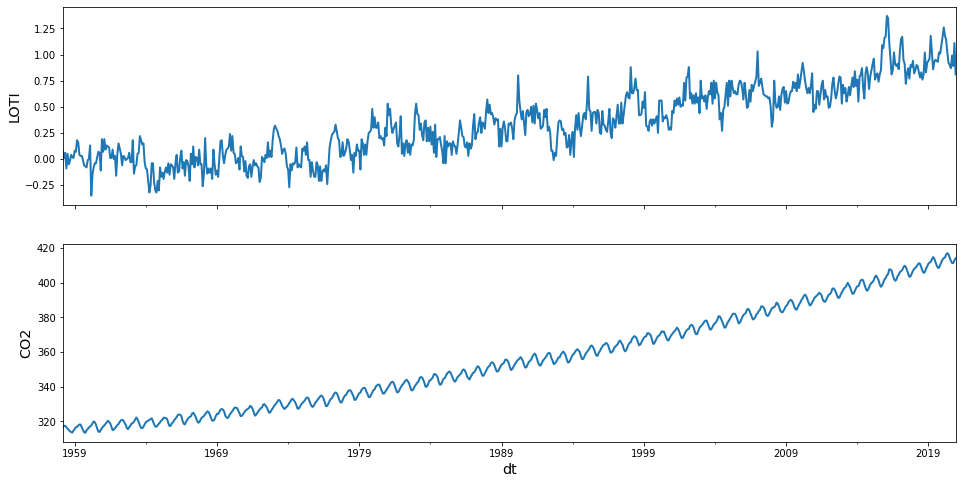

In [170]:
_ = tsf.viz.plot_time_series(
    [data["LOTI"], data["CO2"]],
    labels=["LOTI", "CO2"],
    figsize=(16, 8)
)

From the time plots above, we can see that both variables are trending upward at what looks to be an increasing rate, so there is indeed a positive correlation between them. Great! Without this, our model wouldn't have anything to learn from, and we'd have to rethink our approach. Although CO2 has a clear annual seasonality, LOTI has irregular ups/downs — "cycles" owing to solar activity, maybe?

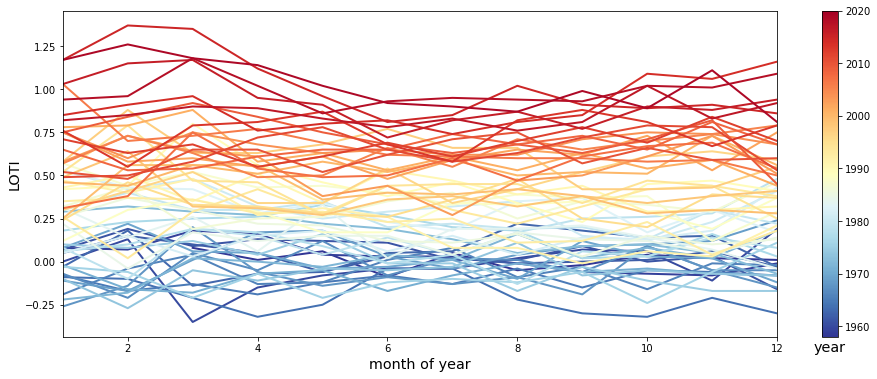

In [171]:
data_grped = data["LOTI"].groupby(by=data.index.year)

fig, ax = plt.subplots()
cmap = plt.cm.get_cmap(name="RdYlBu_r")
cmap_norm = mpl.colors.Normalize(vmin=data.index.year.min(), vmax=data.index.year.max())
for i, (year, grp) in enumerate(data_grped):
    ax.plot(grp.index.month, grp.values, color=cmap(i / len(data_grped)), label=year)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=cmap_norm, cmap=cmap), ax=ax)
cbar.ax.set_xlabel("year")
_ = ax.set_ylabel("LOTI")
_ = ax.set_xlabel("month of year")
_ = ax.set_xlim(left=1, right=12)

From this seasonal plot, we can see that the time series of temperature _anomalies_ doesn't have a strong seasonal component. This is likely because each month's temperature is compared to the corresponding month's temperature averaged over the reference period — that is, the values are normalized by both time and place. Still, it looks as if recent winter months are more often seeing larger temperature anomalies than summer months.

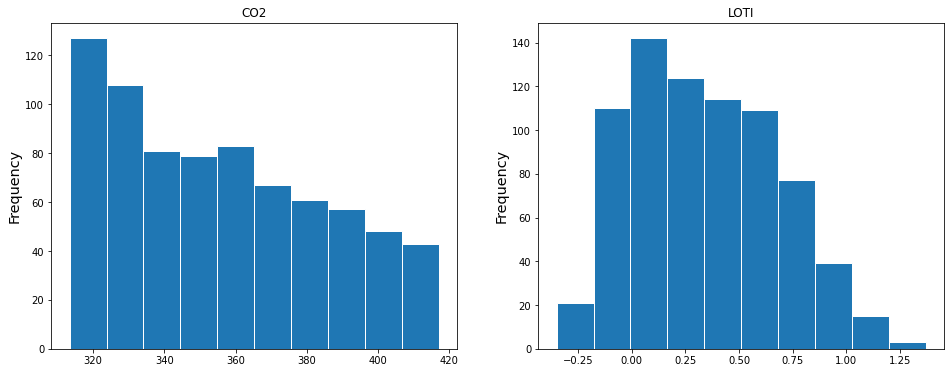

In [172]:
fig, axes = plt.subplots(ncols=2)
_ = data["CO2"].plot.hist(title="CO2", ec="white", ax=axes[0])
_ = data["LOTI"].plot.hist(title="LOTI", ec="white", ax=axes[1])

Both our predictor and forecast variables aren't normally distributed, with `CO2` more significantly skewed, but the method through we which we'll fit our model (ordinary least squares aka OLS) doesn't require normality of the variables here. Plus, the skew isn't _too_ extreme, so no need to transform the variables via logarithm or Box-Cox.

Now, let's better describe the relationship between the two variables.

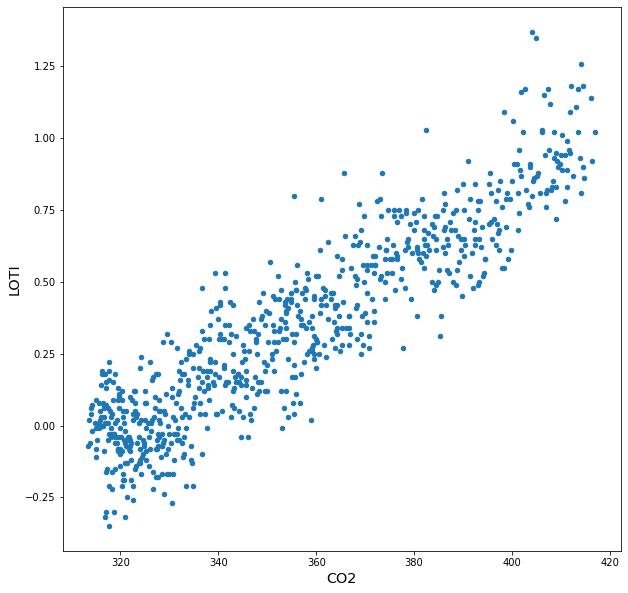

In [173]:
_ = data.plot.scatter("CO2", "LOTI", figsize=(10, 10))

Again we see a strong, linear relationship between the predictor and forecast variables. We also don't see any obvious outlier values, so we won't have to remove observations or otherwise worry about skewed regression model fits.

In [174]:
data.corr(method="spearman")

,CO2,LOTI
CO2,1.000000,0.906585
LOTI,0.906585,1.000000


As anticipated, there's a strong positive correlation of ~0.91 between the predictor and forecast variables, where for the Spearman rank correlation used above, +1 or -1 indicates a perfect monotonic relationship and 0 indicates no relationship between the ranked values.

Based on what we found in step 2, we can be fairly confident that increasing CO2 concentrations in the atmosphere do indeed _cause_ increasingly positive temperature anomalies. However, it's important to note that, when it comes to forecasting, we don't actually need a _causal_ relationship — a correlation will do just fine! Including causal relationships in a model can make for better, more interpretable forecasts, but oftentimes the phenomenon under study has complex and/or unmeasured causes.

### model training and evaluation

Now we're ready to fit a standard linear model to the data — no need for specialized time series models. In this situation, I generally prefer `scikit-learn`'s functionality and API to `statsmodels` — though either should work just fine — because it's focused on ease-of-use, fitting the best model possible, and making predictions with it. That said, `statsmodels` offers much more in the way of model diagnostics and statistical tests that we'll otherwise have to implement ourselves, if needed.

Without further ado, let's fit a linear model to our data using least squares estimation, which finds the coefficients $\beta_{0}$ and $\beta_{1}$ that minimize the sum of squared errors. We'll do a simple split of the full dataset into training and test sets, where the test set is comprised of the most recent 10 years of observations — a decent approximation of the forecast we'd like to make.

In [175]:
nobs_test = 12 * 10
data_train = data.iloc[:-nobs_test, :]
data_test = data.iloc[-nobs_test:, :]
data_train.shape, data_test.shape

((634, 2), (120, 2))

In [176]:
# # the statsmodels equivalent...
# endog = data_train["LOTI"]
# exog = data_train["CO2"].astype(float)

# model = sm.OLS(endog, exog).fit()
# model.summary()

In [177]:
X_train = data_train[["CO2"]].astype(float)
# X_train = data_train[["CO2"]].rolling(window=12, min_periods=1).mean().rolling(window=2, min_periods=1).mean()
y_train = data_train["LOTI"]

model = sklearn.linear_model.LinearRegression(fit_intercept=True).fit(X_train, y=y_train)
model

LinearRegression()

In [178]:
print(f"beta0 = {model.intercept_}\nbeta1 = {model.coef_[0]}")

beta0 = -3.4206568539261357
beta1 = 0.010577332694586201


Let's interpret our fit model's parameters:

- The expected global temperature anomaly at a CO2 concentration of 0 ppm would be -3.4ºC. However, given the complex dynamics of the system we're modeling, it's likely that our simple linear relationship will _not_ continue to an extreme value of `CO2 = 0`. The intercept term is important to our model, but we should always keep in mind the limits of its applicability.
- For every 1ppm increase in atmospheric CO2 concentration, we expect an increase of 0.01ºC in global temperature anomaly. That doesn't sound like much until you consider how quickly CO2 concentrations have been rising year-over-year...

In [179]:
yhat = pd.Series(data=model.predict(X_train), index=y_train.index)
residuals = y_train - yhat

Let's see how our fitted values (in-sample predictions) compare to the true values:

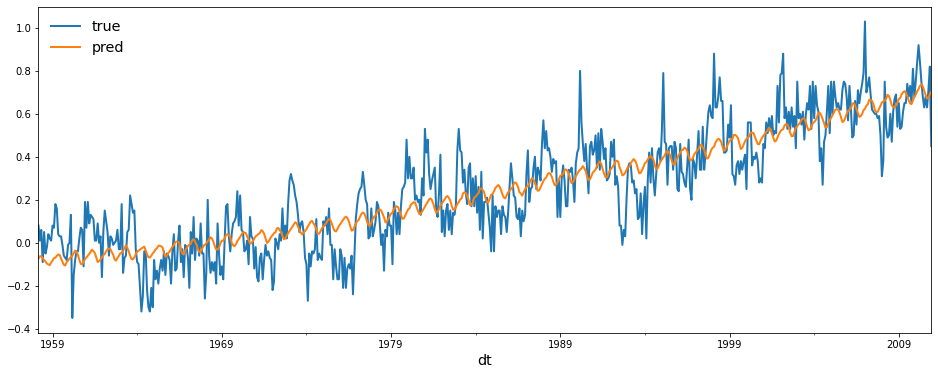

In [180]:
_ = tsf.viz.plot_time_series([y_train, yhat], labels=["true", "pred"], subplots=False)

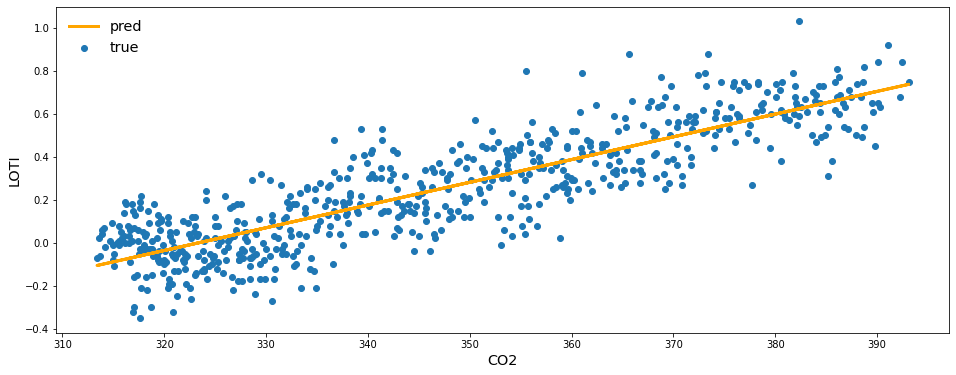

In [181]:
fig, ax = plt.subplots()
_ = ax.scatter(data_train["CO2"].astype(float), y_train, label="true")
_ = ax.plot(data_train["CO2"].astype(float), yhat, lw=3, label="pred", color="orange")
_ = ax.set_xlabel("CO2")
_ = ax.set_ylabel("LOTI")
_ = ax.legend()

Not _bad_, actually, for a simple linear regression model with only one predictor variable. Let's check the goodness of fit using a couple different metrics:

- **mean squared error:** $\text{MSE} \left( y, 
\hat{y} \right) = \frac{1}{T} \sum \left( y_{t} - \hat{y}_{t} \right)^{2}$, which measures the quality of a fit model based on its variance and bias; values closer to 0 are better
- **coefficient of determination:** $R^{2} \left( y, \hat{y} \right) = 1 - \left( \sum \left( y_{t} - \hat{y}_{t} \right)^{2} / \sum \left( y_{t} - \bar{y} \right)^{2} \right)$, which gives the proportion of variation in the dependent variable accounted for by the independent variable(s); it typically ranges from 1.0 (predicted and observed values are identical) to 0 (no relationship between predicted and observed values)
- **Adjusted $R^{2}$:** $R_{adj}^{2} = 1 - \left( \left( 1 - R^{2} \right) \left( T - 1 \right) / \left( T - p - 1 \right) \right)$, which adjusts the standard to penalize increasing number of predictor variables and avoid over-fitting; its value is similar to but strictly less than $R^{2}$

In [182]:
sklearn.metrics.mean_squared_error(y_train, yhat, squared=True)

0.018524398561789265

In [183]:
sklearn.metrics.r2_score(y_train, yhat)

0.7498544932448972

In [184]:
tsf.stats.adjusted_r2_score(y_train, yhat, model)

0.7494586933924365

We should also check the residuals to ensure that the assumptions we've made in using this linear regression model hold:

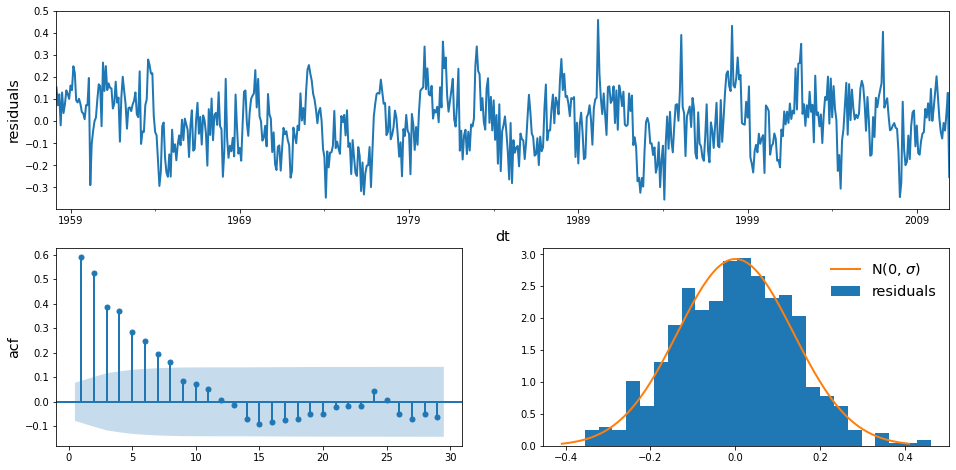

In [185]:
_ = tsf.viz.plot_residuals_diagnostics(residuals, acf_kw={"zero": False}, hist_kw={"bins": 25}, figsize=(16, 8))

In [186]:
sm.stats.stattools.durbin_watson(residuals)

0.8129484501083963

The residual values are indeed distributed normally about zero, which is good.

There's some amount of positive autocorrelation, as visible in the correlogram as well as Durbin-Watson test statistic (values range from 0 to 4, where 2 indicates no autocorrelation; we're roughly in the middle of the positive range). As a result, our forecast intervals may be larger than they need to be, or we may consider adding lagged values of the dependent variable to the model to reduce the residuals' autocorrelation.

We also want to make sure that they're not related to the dependent variable or fitted values:

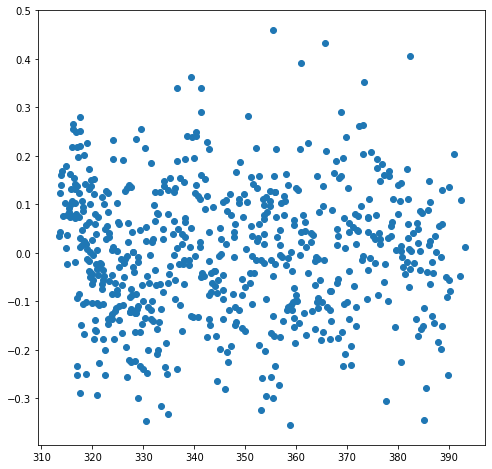

In [187]:
fig, ax = plt.subplots(figsize=(8, 8))
_ = ax.scatter(data_train["CO2"], residuals)

In [188]:
data_train["CO2"].astype(float).corr(residuals, method="spearman")

-0.022483212667174356

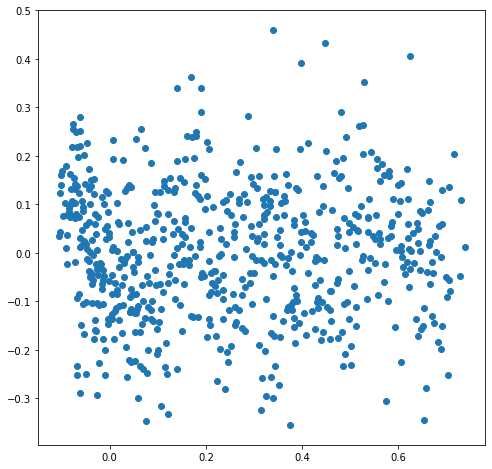

In [189]:
fig, ax = plt.subplots(figsize=(8, 8))
_ = ax.scatter(yhat, residuals)

In [190]:
yhat.corr(residuals, method="spearman")

-0.022483212667174356

All good! Our residuals are _homoscedastic_.

As mentioned in the "time series forecasting basics" notebook, there are fancier ways to split the dataset into train/test sets. One such method is a time series-specific variation of cross-validation, in which the dataset is split into $k$ "folds" (evenly-sized subsets of contiguous values), then the training set is taken to be the first $k$ folds and the test set is the ($k + 1$)th fold. Unlike typical cross-validation strategies, here successive training sets are supersets of the preceding ones.

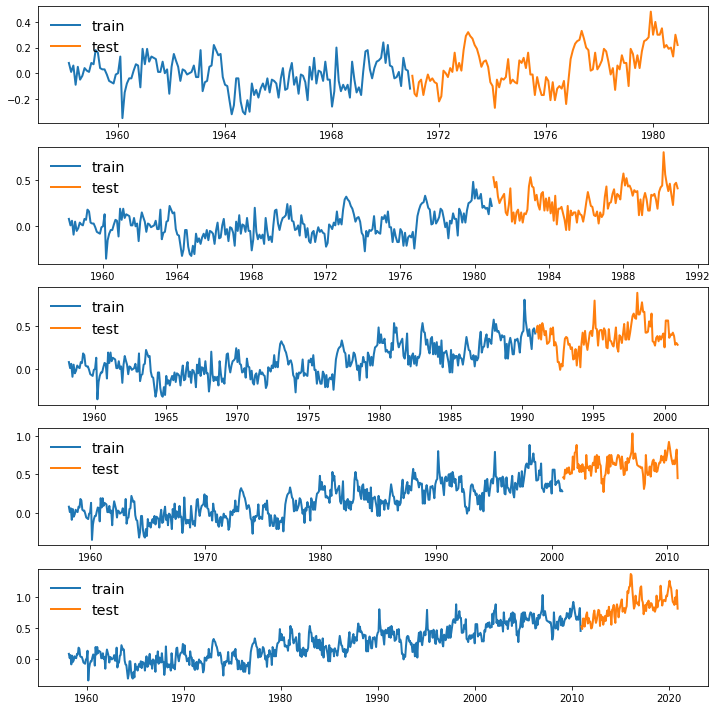

In [191]:
X = data[["CO2"]].astype(float)
y = data["LOTI"]

n_splits = 5
tscv = sklearn.model_selection.TimeSeriesSplit(n_splits=n_splits, gap=0, test_size=nobs_test)

fig, axes = plt.subplots(figsize=(12, 2.5 * n_splits), nrows=n_splits)
for ax, (train_idxs, test_idxs) in zip(axes, tscv.split(X, y=y)):
    data_train = data.iloc[train_idxs, :]
    data_test = data.iloc[test_idxs, :]
    _ = ax.plot(data_train.index, data_train["LOTI"], label="train")
    _ = ax.plot(data_test.index, data_test["LOTI"], label="test")
    _ = ax.legend(loc="upper left")

Note the changing time periods on the x-axis!

In [192]:
cv_scores = sklearn.model_selection.cross_validate(
    sklearn.linear_model.LinearRegression(fit_intercept=True),
    X,
    y,
    cv=sklearn.model_selection.TimeSeriesSplit(n_splits=n_splits, gap=0, test_size=nobs_test),
    scoring={
        "mse": sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False),
        "r2": sklearn.metrics.make_scorer(sklearn.metrics.r2_score, greater_is_better=True),
    },
)
cv_scores

{'fit_time': array([0.002846  , 0.00256324, 0.00263906, 0.00287509, 0.00325799]),
 'score_time': array([0.00208092, 0.00202012, 0.00215197, 0.00220299, 0.002141  ]),
 'test_mse': array([-0.03389716, -0.02847457, -0.0218991 , -0.01744092, -0.02165954]),
 'test_r2': array([-0.39470932, -0.30135789,  0.13150407, -0.19704358,  0.38690303])}

### forecasting

For time series regression models, there are two fundamental types of forecast:

- **ex-ante:** true forecasts that rely only on information available in advance of producing the forecast; unfortunately, this requires estimating future values for each of the predictor variables (e.g. using a fit ETS model to forecast CO2 concentrations)
- **ex-post:** forecasts that use later information about the predictor variables; mostly used for studying the behavior and uncertainty of regression forecasting models

A common case is "scenario-based" forecasting, where forecasts are produced assuming different scenarios for the predictors — for example: high, medium, and low CO2 emissions trajectories.

In [193]:
model = sklearn.linear_model.LinearRegression(fit_intercept=True).fit(data[["CO2"]].astype(float), y=data["LOTI"])
model.intercept_, model.coef_

(-3.447708145202169, array([0.01065387]))

In [194]:
steps = 12 * 10
last_known_co2 = data["CO2"].iat[-1]

In [195]:
def get_mult_factors(start, end, steps):
    return np.arange(start, end, (end - start) / steps)


ets_result = (
    sm.tsa.ETSModel(
        data["CO2"].astype(float),
        trend="mul",
        seasonal="mul",
        error="add",
        seasonal_periods=12,
        initialization_method="estimated",
    )
    .fit()
)
co2_fcast_no_change = ets_result.forecast(steps=steps)
co2_fcast_50pct_2030 = (
    co2_fcast_no_change.iat[0] +
    (co2_fcast_no_change.diff(periods=1).fillna(0.0) * get_mult_factors(1.0, 0.5, steps)).cumsum()
)
co2_fcast_100pct_2030 = (
    co2_fcast_no_change.iat[0] +
    (co2_fcast_no_change.diff(periods=1).fillna(0.0) * get_mult_factors(1.0, 0.0, steps)).cumsum()
)

co2_fcast_scenarios = pd.DataFrame(
    data={
        "no change": co2_fcast_no_change,
        "-50% by 2030": co2_fcast_50pct_2030,
        "net-zero by 2030": co2_fcast_100pct_2030,
    },
    index=co2_fcast_no_change.index,
)
co2_fcast_scenarios

,no change,-50% by 2030,net-zero by 2030
2021-01-01,415.500150,415.500150,415.500150
2021-02-01,416.374138,416.370496,416.366854
2021-03-01,417.452827,417.440196,417.427566
2021-04-01,418.971573,418.939958,418.908343
2021-05-01,419.690578,419.646980,419.603381
...,...,...,...
2030-08-01,437.196857,432.354907,427.512956
2030-09-01,435.295656,431.372619,427.449583
2030-10-01,435.457937,431.455788,427.453640
2030-11-01,437.128020,432.304747,427.481474


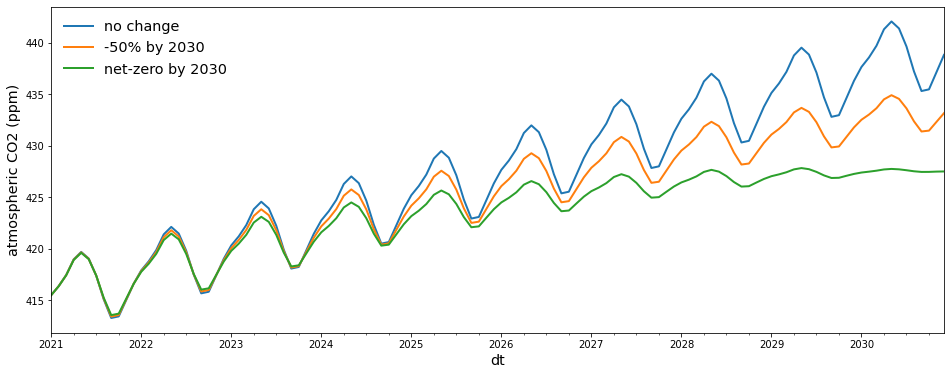

In [196]:
_ = co2_fcast_scenarios.plot(xlabel="dt", ylabel="atmospheric CO2 (ppm)")

Note: These forecasts aren't fancy, and as you can see, I've not bothered to correctly handle seasonality. This is just for example purposes.

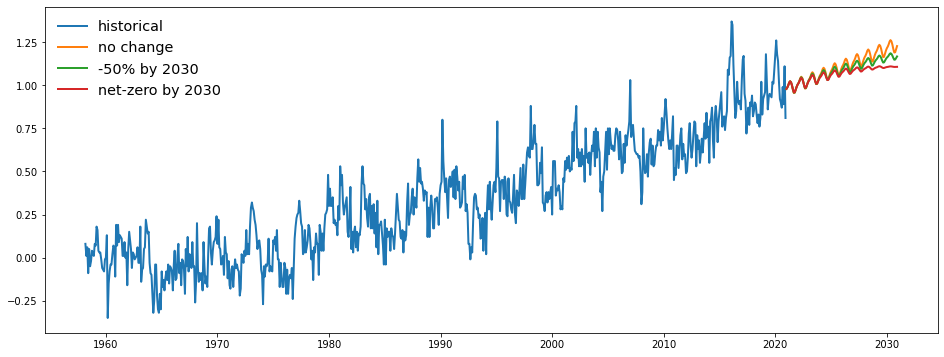

In [197]:
fig, ax = plt.subplots()
ax.plot(data.index, data["LOTI"], label="historical")
ax.plot(co2_fcast_scenarios.index, model.predict(co2_fcast_scenarios[["no change"]]), label="no change")
ax.plot(co2_fcast_scenarios.index, model.predict(co2_fcast_scenarios[["-50% by 2030"]]), label="-50% by 2030")
ax.plot(co2_fcast_scenarios.index, model.predict(co2_fcast_scenarios[["net-zero by 2030"]]), label="net-zero by 2030")
_ = ax.legend()

In [198]:
# model.predict(co2_fcast_scenarios[["net-zero by 2030"]].iloc[-1:]) - model.predict(co2_fcast_scenarios[["net-zero by 2030"]].iloc[:1])

Under the baseline "no change" scenario, the model forecasts an increase of ~0.25ºC in global mean temperature anomaly come 2030; under the extremely optimistic "net-zero by 2030" scenario, the increase is still ~0.13ºC. Clearly, global warming and related climate change will continue getting worse for the next decade (and beyond) — how _much_ worse is up to us.